# Testing state abstraction on Ott's data

Now that we have established that the bayesian hierarchical models we have devised are able to 

While we aim to collect a whole new data set for this project, we can nontheless test whether our state abstraction model of existing data. The design we aim to use is adapted Ott et al.'s design. For our purpose, we will increase the number of states compared to the original, to make it more difficult for participants to solve the MDP to push them to resort to abstraction. Therefore, the original design is not necessarily geared toward state abstraction. Nonetheless, participants were observed to behave suboptimally in the original design, which might indicate that already the state space size of the original study might be too large for participants to deal with. We can therefore test our state abstraction model on these data. First, we will compute the pairwise distances of each states in the original state space, generate abstracted MDP at various $\epsilon$ levels ($\epsilon=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]$) and compare the results of that model to the model from Ott et al.

## Compute pairwise distances:

In [ ]:
import numpy as np
import pandas as pd
import os
from scipy.stats import zscore
from stabst.utils import plot_state_matrix, beh_barplot, abstract2ground_value
from scipy.special import expit
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import arviz as az
import pymc as pm


# ===================================================================================
# Prepare the data:
# Download data from Florian's repo:
data = pd.read_csv("../data/raw_data/all_participants_data.csv", on_bad_lines='skip')
# Remove nans:
data = data.dropna()
# Flip responses: 1 = accept:
data["response"] = np.abs(data["response"] - 1)
# Make trial 1 based
data["trial"] = data["trial"] + 1
# Remove the 
# Get subject IDs:
subj_idx_raw, subj_labels = pd.factorize(data["vpn"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}
transitions_costs = {
    0: [1, 1],
    1: [2, 1],
    2: [1, 2],
    3: [2, 2]
}
data["fc"] = [transitions_costs[row["transition"]][1] for _, row in data.iterrows()]

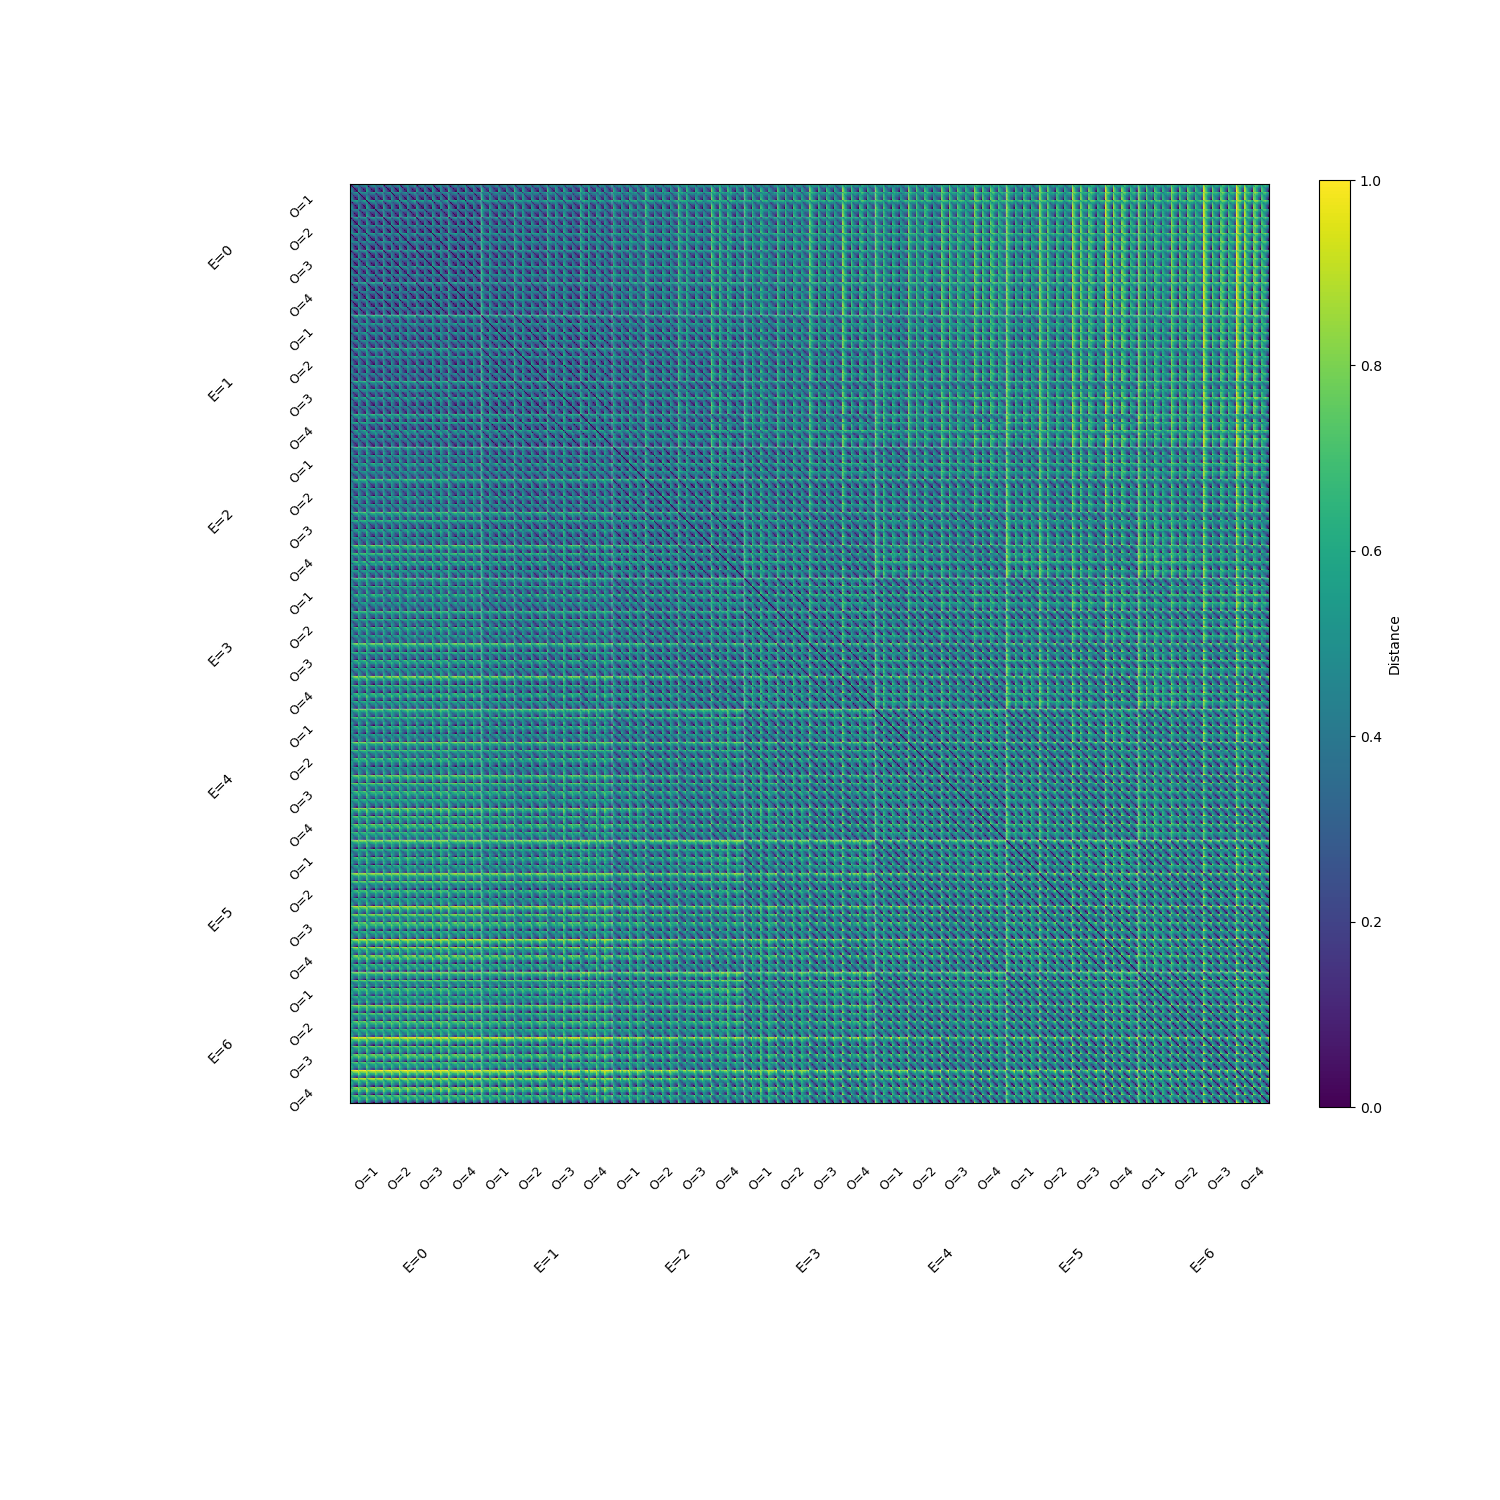

In [13]:
# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()

# Create full MDP and compute solution for later reference:
gamma = 0.99
task_mdp = MDP(task.states, task.tp, task.r, gamma, s2i=task.s2i)
V_full, Q_full = task_mdp.backward_induction()
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)

# Compute pairwise distances:
if not os.path.isfile(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy'):
    distances_matrix = task_mdp.bisim_metric(gamma=0.99, tol=1e-3, njobs=-1, max_iters=1000)
    distances_matrix = distances_matrix / np.max(distances_matrix)
    if not os.path.isdir("../data/bids/limited_energy/derivatives/state_abstraction"):
        os.makedirs("../data/bids/limited_energy/derivatives/state_abstraction")
    np.save(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy', distances_matrix)
else:
    distances_matrix = np.load(f'../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix_gamma_{gamma}.npy')

# Plot the distance matrix:
plot_state_matrix(distances_matrix, task.states, feature_names=["E", "O", "CC", "FC", "T"], depth=2)
plt.show()

# Compute decision values for each abstraction level:

In [14]:
unique_dist = np.unique(np.round(distances_matrix, decimals=3))
n_states = len(task_mdp.states)
abstraction_distances = []
DVs = []

for eps in unique_dist: #unique_dist:
    # Generate abstracted MDP at that level of abstraction:
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps + 0.0001, distance_matrix=distances_matrix)
    if n_states - len(abstract_mdp.states) < 10:
        continue
    else:
        n_states = len(abstract_mdp.states)
        abstraction_distances.append(eps)
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Project back to Ground space:
    V_from_abstract, Q_from_abstract = abstract2ground_value(class_of_state, V_R, Q_R)
    # Add to decision values
    DVs.append(zscore(Q_from_abstract[:, 1] - Q_from_abstract[:, 0]))

## Prepare data for model fitting:

In [15]:
# Add the decision value associated with each epsilons:
for eps_i, eps in enumerate(abstraction_distances):
    # Get the decision value:
    if eps == 0:
        dv = Q_full[:, 1] - Q_full[:, 0]
    else:
        dv = DVs[eps_i]
    # Loop through each trial to set DV:
    dv_trials = []
    mdl_sim_resps = []
    decision_match = []
    for trial_i, trial in data.iterrows():
        e, o, cc, t = trial.energy, trial.reward, trial.energy_cost, trial.trial
        fc = transitions_costs[trial.transition][1]
        dv_trials.append(dv[task.s2i[(e, o, cc, fc, t)]])
        # Simulate data according to that plan:
        mdl_sim_resps.append(np.random.binomial(1, expit(dv[task.s2i[(e, o, cc, fc, t)]])))
        decision_match.append(1 - np.abs(trial.response - mdl_sim_resps[-1]))
    data[f'DV-eps: {eps}'] = dv_trials


In [16]:
# Extract the data of one subject:
subj_idx_raw, subj_labels = pd.factorize(data["vpn"])
coords = {
    "subject": subj_labels,
    "coef": ["intercept", "slope"],
}

with pm.Model(coords=coords) as hierarchical_binomial_regression:
    y_obs = pm.Data("y_obs", data["response"])
    dv = pm.Data("Decision values", data[f"DV-eps: {0.0}"])
    subj_idx = pm.Data("subj_idx", subj_idx_raw)

    # Population level priors:
    beta_pop = pm.Normal("beta_pop", mu=0, sigma=2, dims="coef")
    sigma_pop = pm.HalfNormal('sigma_pop', sigma=2, dims="coef")
    # Non centered parametrization of within subject coefficients
    z = pm.Normal("z", 0, 1, dims=("subject", "coef"))
    beta_sub = pm.Deterministic("beta_sub", beta_pop + z * sigma_pop, dims=("subject","coef"))

    # Likelihood
    p = pm.Deterministic("p", pm.math.sigmoid(beta_sub[subj_idx, 0] + beta_sub[subj_idx, 1] * dv))
    pm.Bernoulli("y", p=p, observed=y_obs)


with hierarchical_binomial_regression:
    idata =  pm.sample(1000, tune=1000, idata_kwargs={"log_likelihood": True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


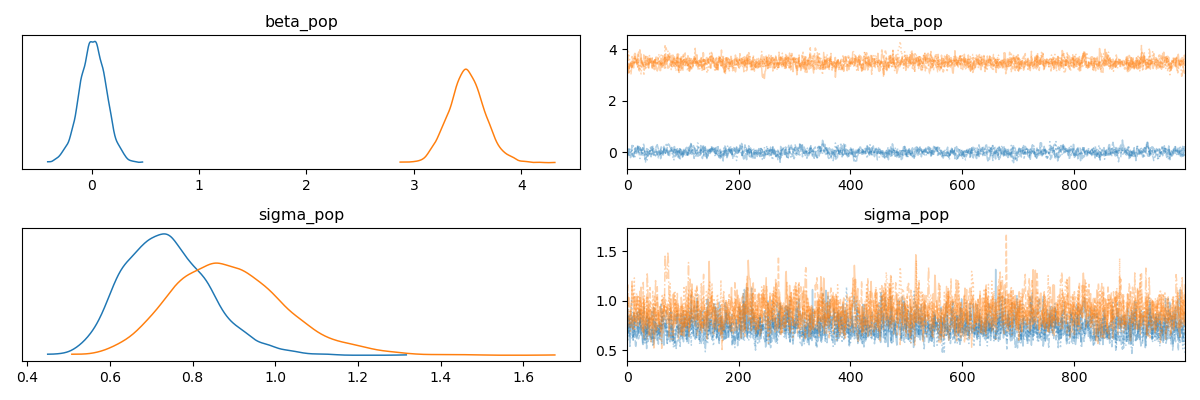

In [17]:
az.plot_trace(idata, var_names=["beta_pop", "sigma_pop"], combined=True);
plt.tight_layout()

In [18]:
az.summary(idata, var_names=["beta_pop", "sigma_pop"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_pop[intercept]   0.011  0.123  -0.218    0.254      0.004    0.002   
beta_pop[slope]       3.492  0.170   3.159    3.799      0.004    0.004   
sigma_pop[intercept]  0.737  0.103   0.555    0.932      0.003    0.002   
sigma_pop[slope]      0.888  0.138   0.630    1.141      0.004    0.002   

                      ess_bulk  ess_tail  r_hat  
beta_pop[intercept]      936.0    1655.0    1.0  
beta_pop[slope]         1517.0    1845.0    1.0  
sigma_pop[intercept]    1266.0    1975.0    1.0  
sigma_pop[slope]        1528.0    2025.0    1.0

In [19]:
traces = {}
for eps_i, eps in enumerate(abstraction_distances[0:7]):
    # Model the data:
    with hierarchical_binomial_regression:
        pm.set_data({"Decision values": data[f'DV-eps: {eps}']})
        traces[f'DV, eps={eps}'] = pm.sample(1000, tune=1000, idata_kwargs={"log_likelihood": True})
        data[f'p(y=1|y_obs)@eps={eps}'] = traces[f'DV, eps={eps}'].posterior.p.mean(dim=["chain", "draw"])
# Compare models:
model_comparison = az.compare(traces)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_pop, sigma_pop, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
/home/alex-lepauvre/miniforge3/envs/pymc_env/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/alex-lepauvre/miniforge3/envs/pymc_env/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


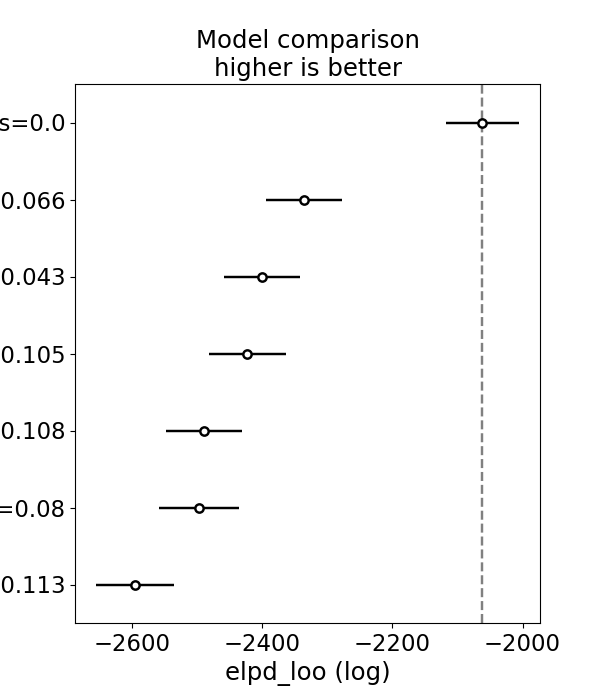

In [20]:
# Compare models:
model_comparison = az.compare(traces)
az.plot_compare(model_comparison);

# Plotting the results:
To evalute the fit of the data, we will plot the data alongside the posterior, to evaluate how well each abstraction level is doing:

(<Figure size 2000x1000 with 4 Axes>,
 array([<Axes: title={'center': 'cc=1, fc=2'}, ylabel='Value'>,
        <Axes: title={'center': 'cc=2, fc=2'}>,
        <Axes: title={'center': 'cc=2, fc=1'}, xlabel='Offer (reward)', ylabel='Value'>,
        <Axes: title={'center': 'cc=1, fc=1'}, xlabel='Offer (reward)'>],
       dtype=object))

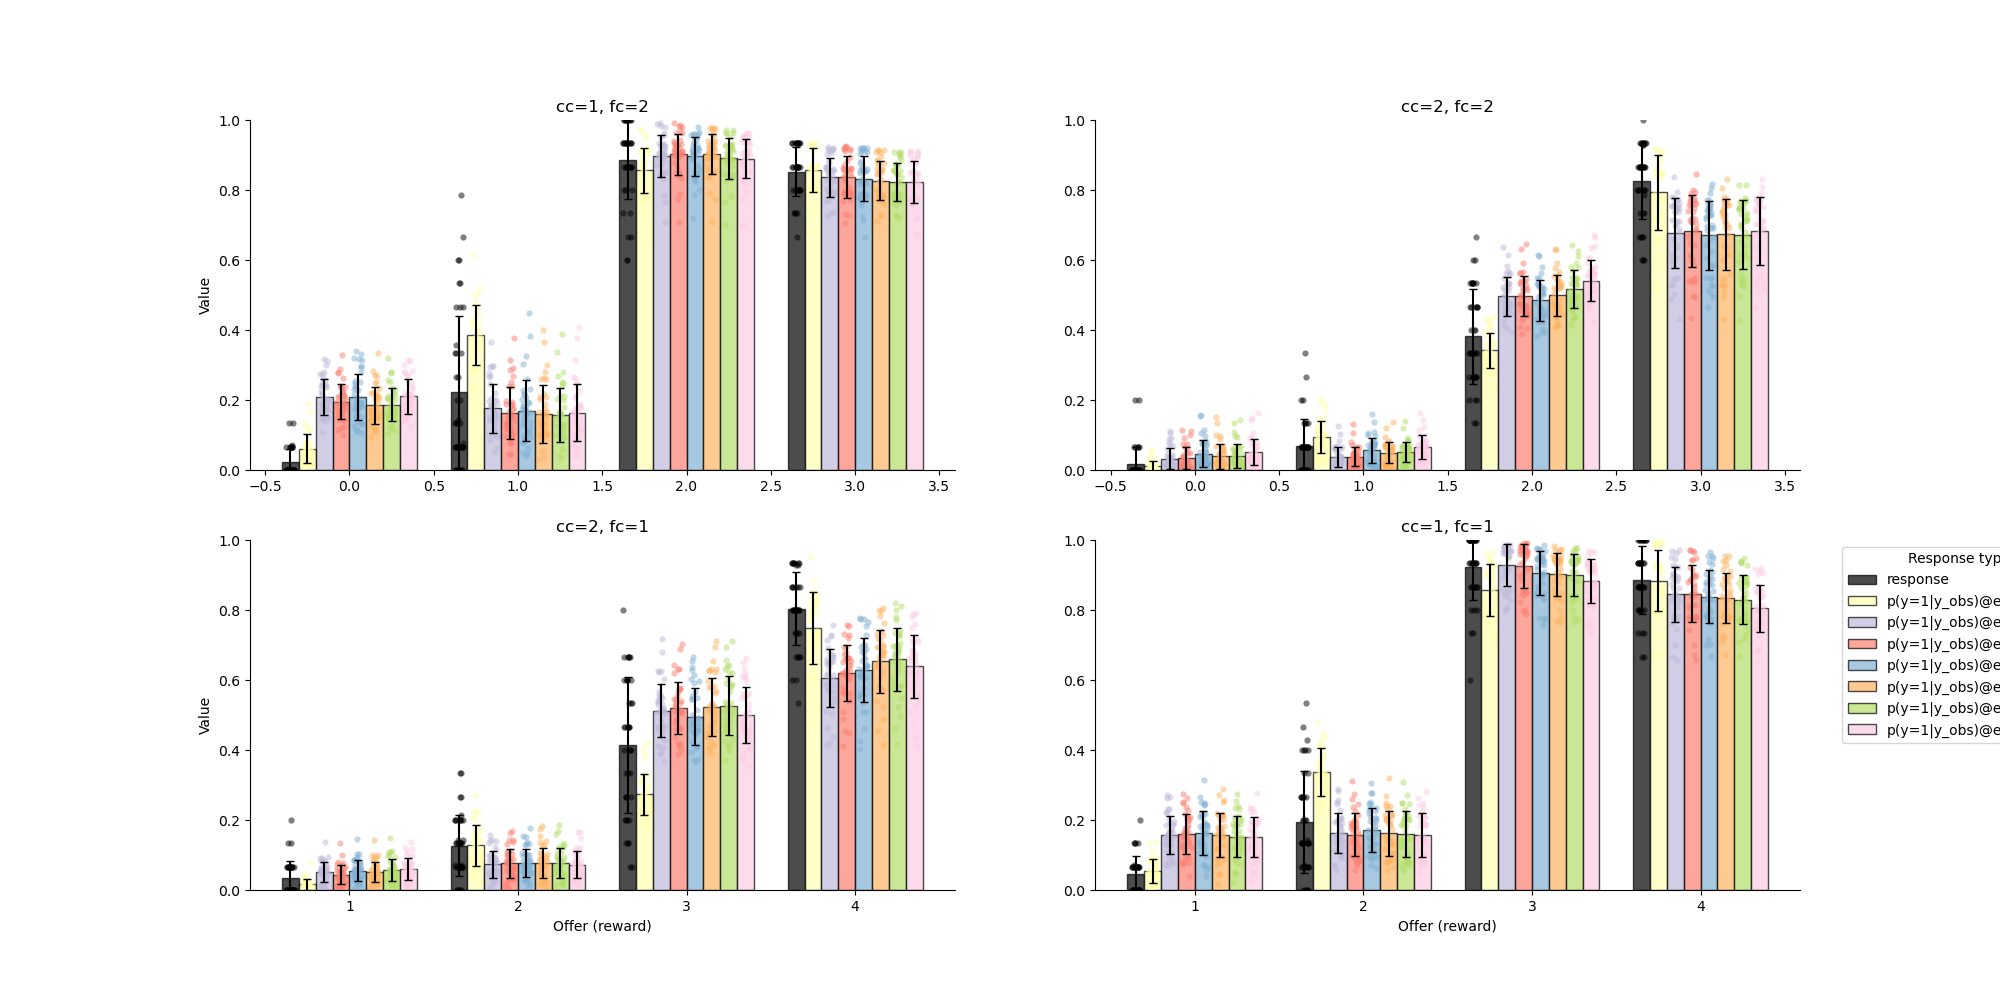

In [21]:
beh_barplot(data, abstraction_distances[0:7], transitions_costs, "p(y=1|y_obs)@eps=")

The plotting of the results go in the direction of the model comparison: the model without abstraction performs overall closest to the actual participants behaviours. But to be sure, let's have a look in more details in each condition:

(<Figure size 1200x800 with 17 Axes>,
 array([[<Axes: title={'center': 'Offer = 1'}, ylabel='cc=1, fc=1 \n Energy'>,
         <Axes: title={'center': 'Offer = 2'}>,
         <Axes: title={'center': 'Offer = 3'}>,
         <Axes: title={'center': 'Offer = 4'}>],
        [<Axes: ylabel='cc=1, fc=2 \n Energy'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='cc=2, fc=1 \n Energy'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: xlabel='Trials', ylabel='cc=2, fc=2 \n Energy'>,
         <Axes: xlabel='Trials'>, <Axes: xlabel='Trials'>,
         <Axes: xlabel='Trials'>]], dtype=object))

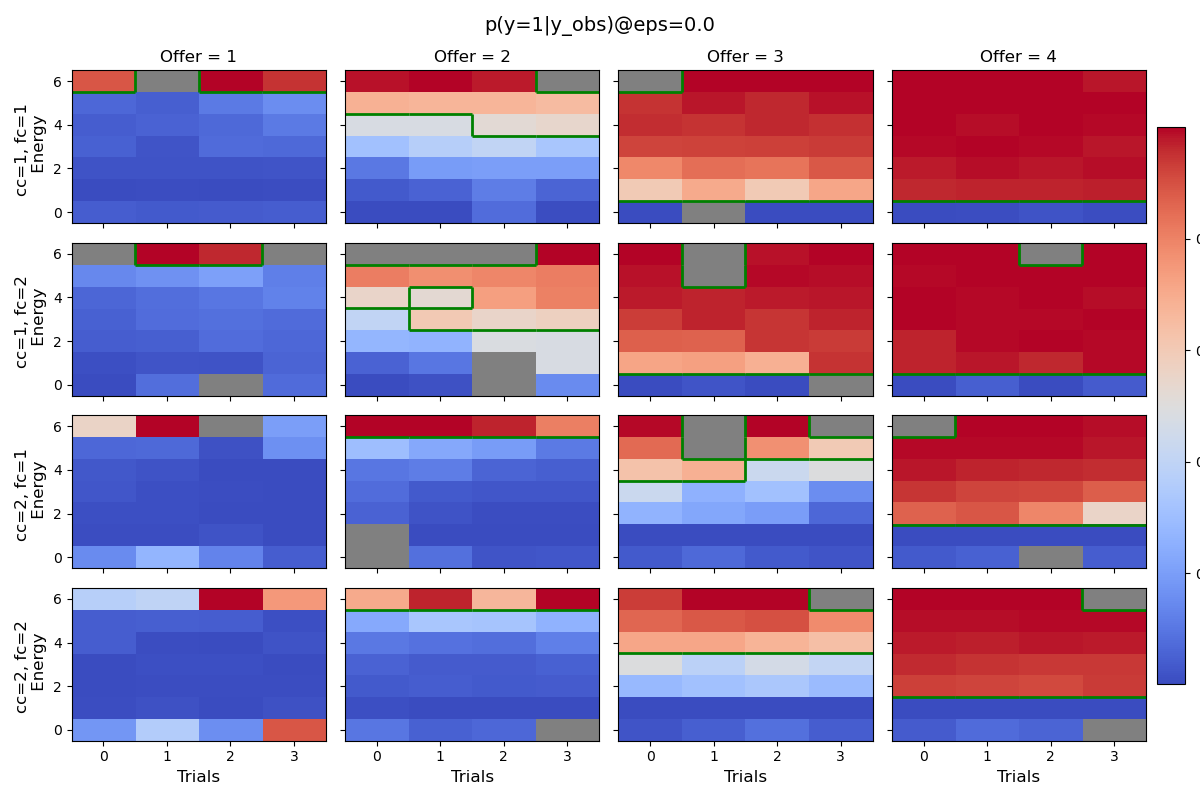

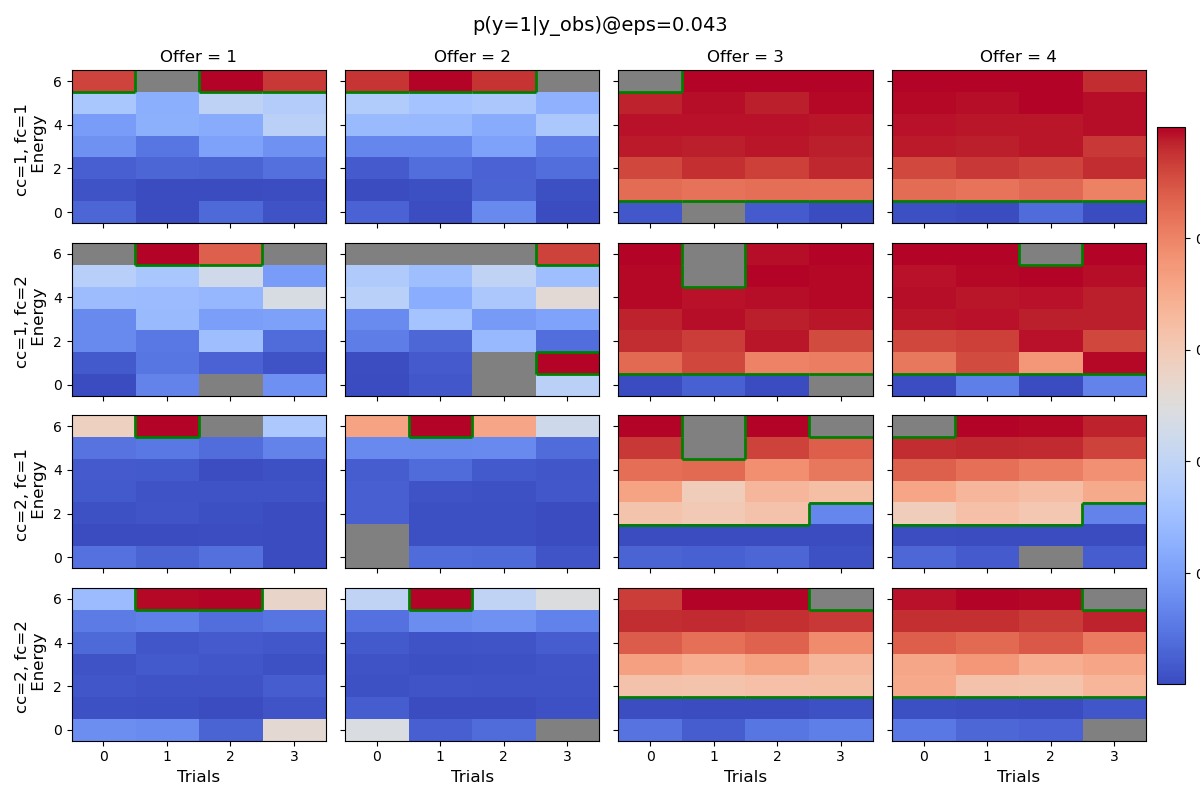

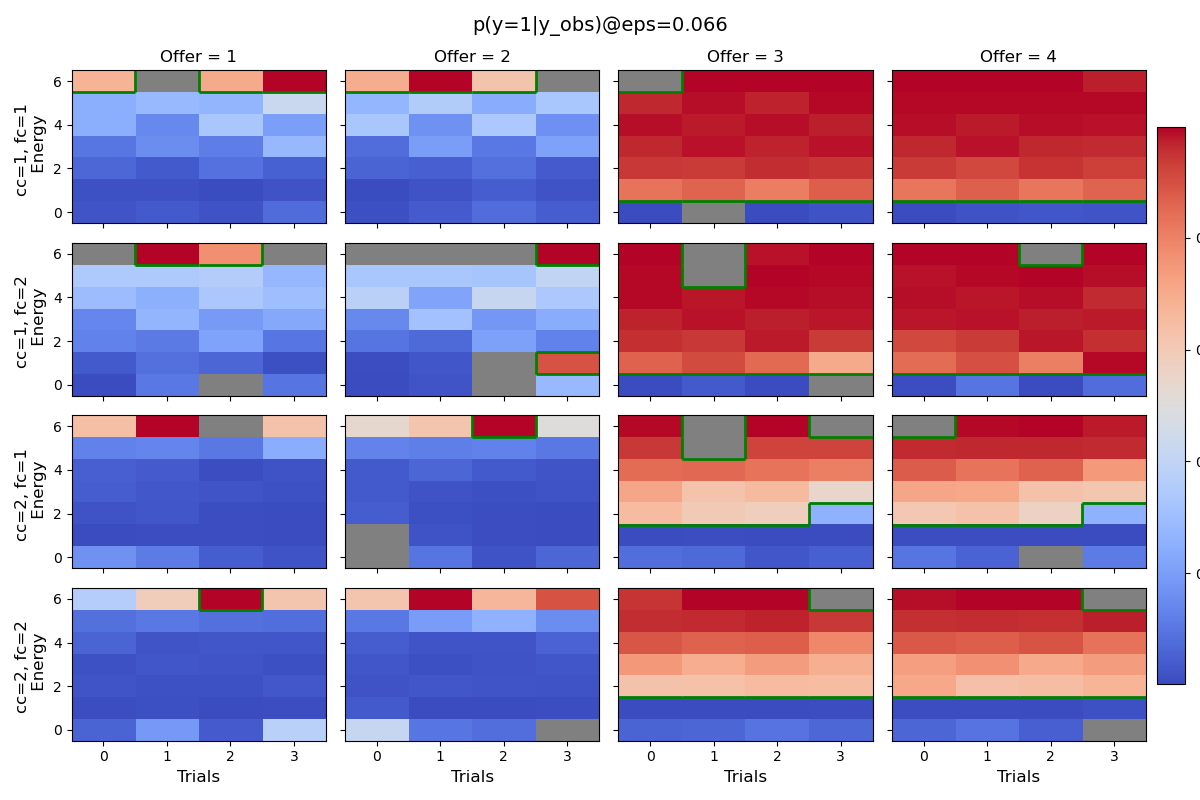

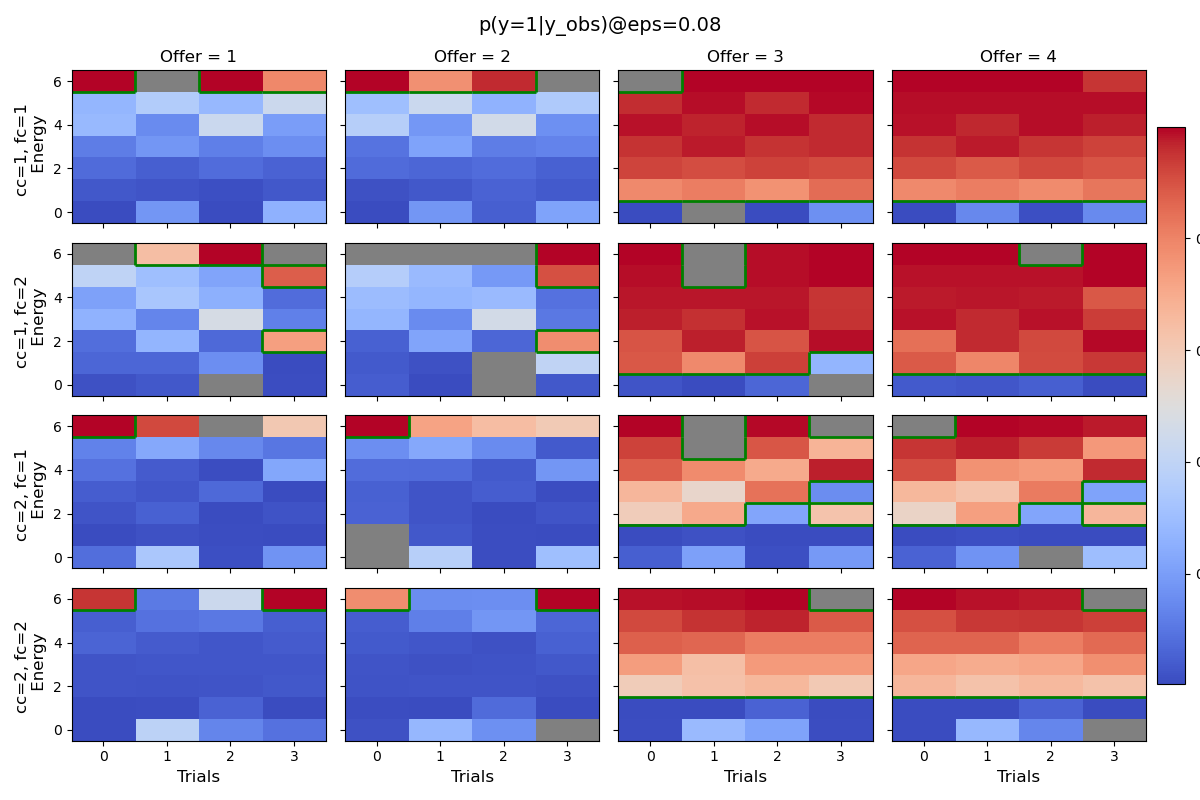

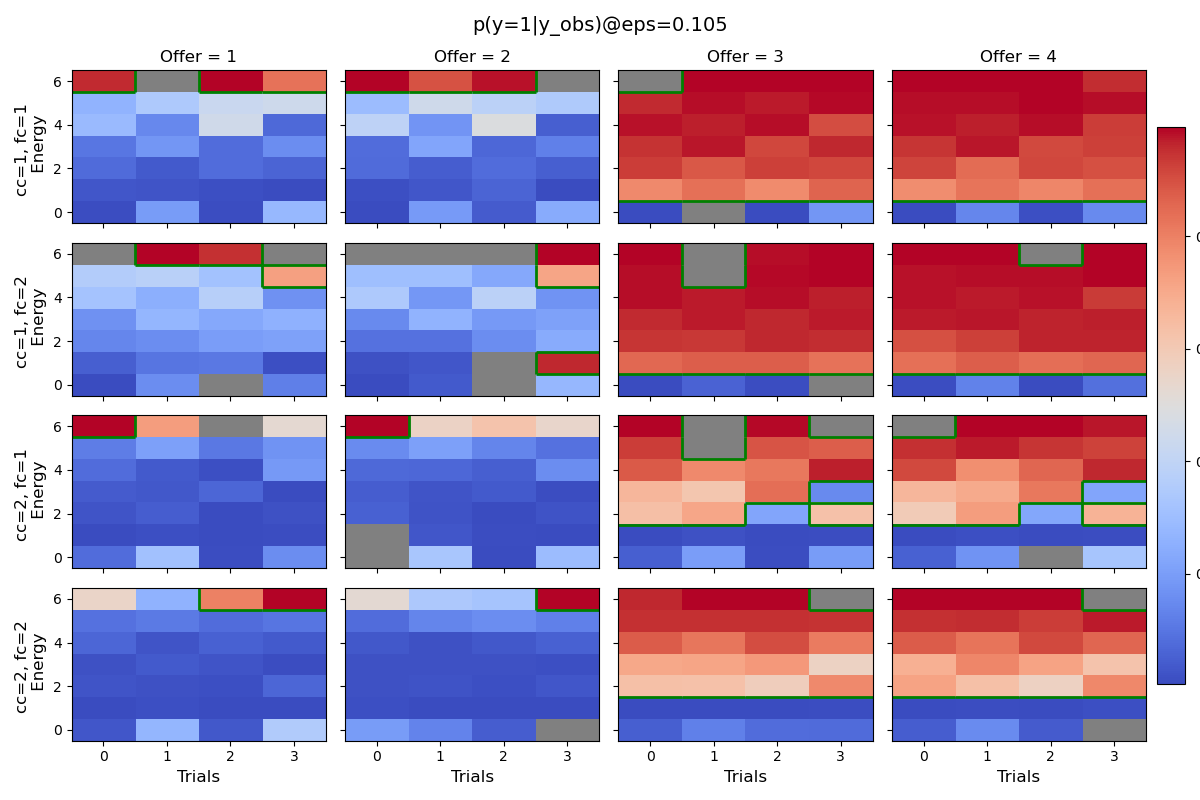

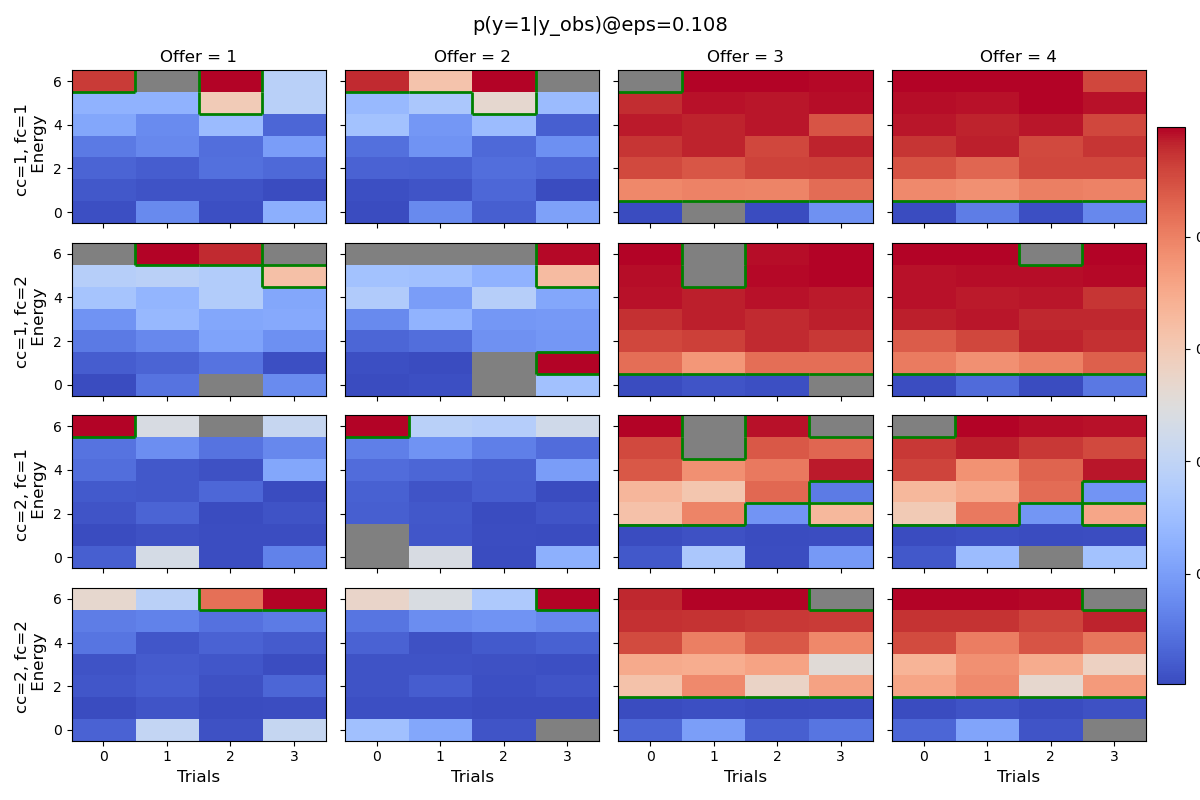

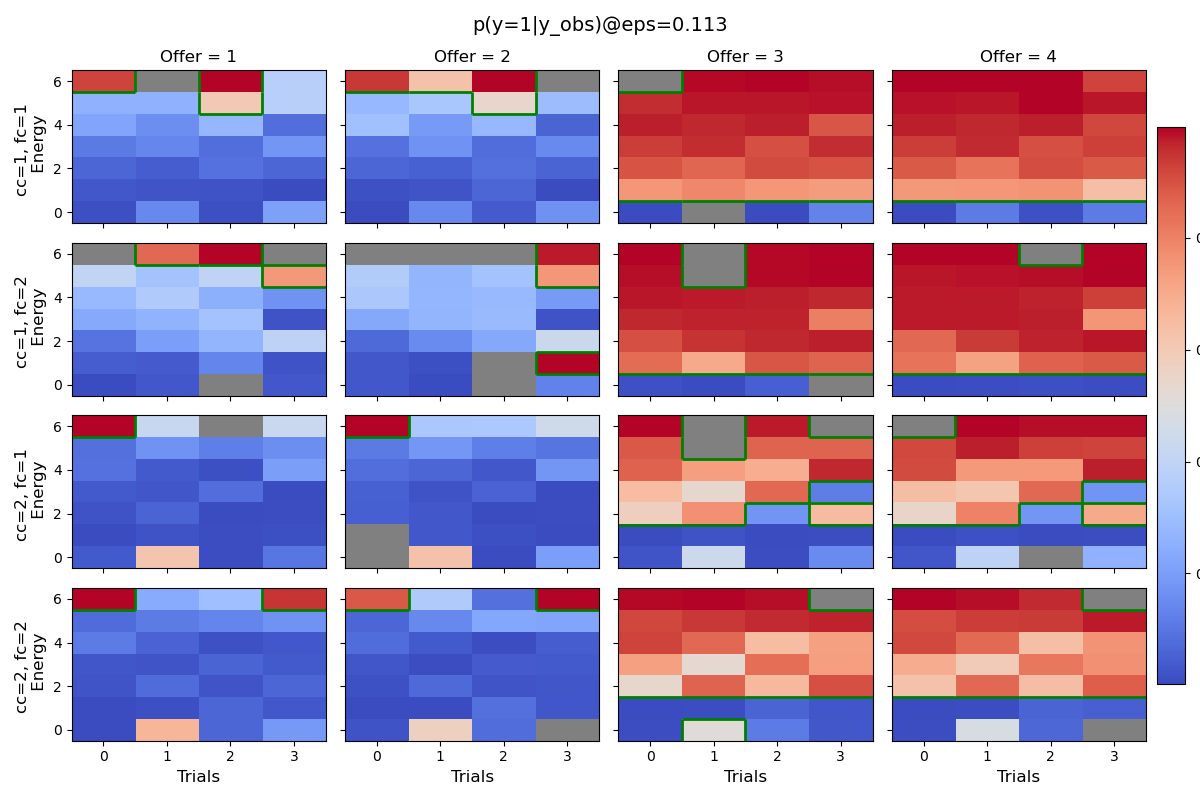

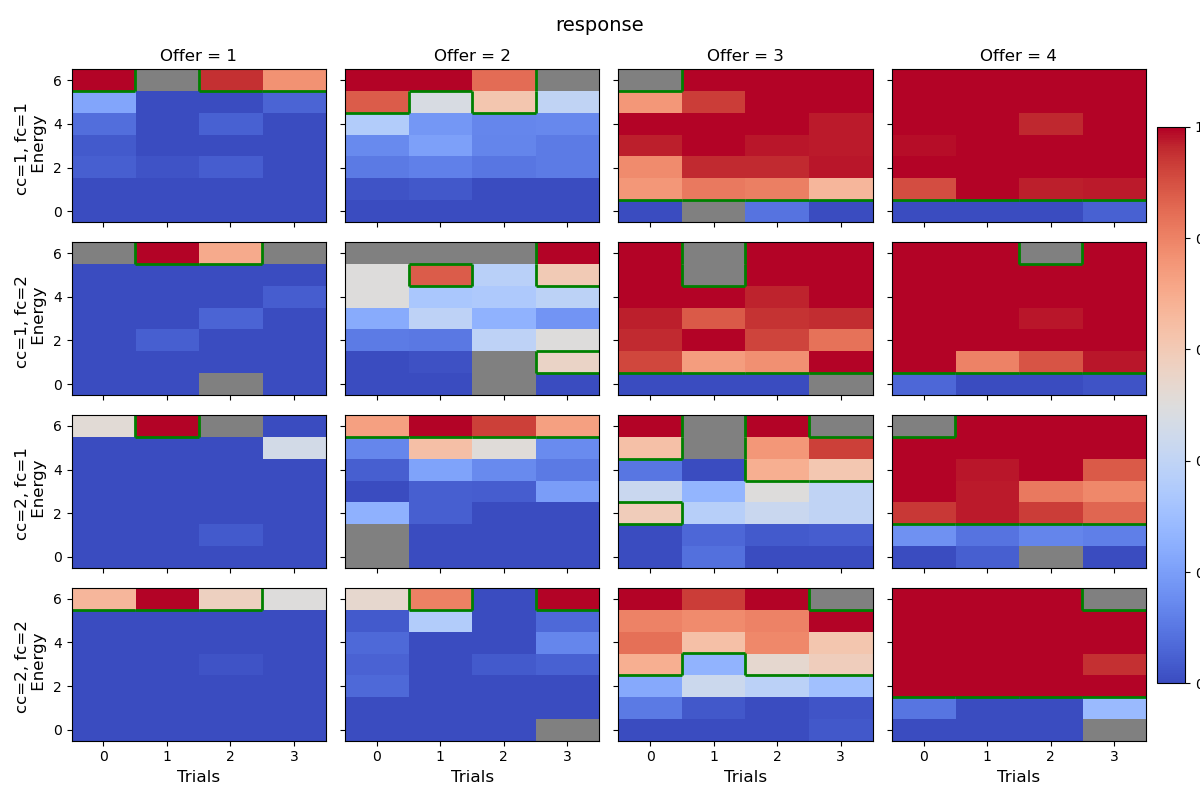

In [22]:
# Loop through each abstraction distances:
state_cols = ["energy", "reward", "energy_cost", "fc", "trial"]
cmap = plt.get_cmap('coolwarm')
cmap.set_bad("grey")
for eps in abstraction_distances[0:7]:
    mean_resp = np.empty(len(task_mdp.states))
    for state in task_mdp.states:
        mean_resp[task_mdp.s2i[*state]] = data.loc[(data[state_cols].to_numpy() == state).all(axis=1), f'p(y=1|y_obs)@eps={eps}'].mean()
    # Plot:
    task_mdp.plot_dv(mean_resp, title=f'p(y=1|y_obs)@eps={eps}', tmax=4, cmap=cmap, cmap_midpoint=0.5, boundary_threshold=0.5)

mean_resp = np.empty(len(task_mdp.states))
for state in task_mdp.states:
    mean_resp[task_mdp.s2i[*state]] = data.loc[(data[state_cols].to_numpy() == state).all(axis=1), 'response'].mean()
# Plot:
task_mdp.plot_dv(mean_resp, title='response', tmax=4, cmap=cmap, cmap_midpoint=0.5, boundary_threshold=0.5)